
# White dwarfs

  White dwarfs are the final evolutionary state of stars whose mass is
  not high enough to become a neutron star or a black hole.  After the
  hydrogen–fusing ($\mathrm{H} \to \mathrm{He}$) lifetime of a star
  ends, such a star fuses helium to carbon and oxygen,
  ($\mathrm{He} \to \mathrm{C, \, O}$). If a star has insufficient
  mass to generate the core temperatures required to further fuse
  carbon and oxygen, an inert mass of carbon and oxygen builds up at
  its center. After shedding its outer layers, the star leaves behind
  the core, which is the white dwarf.

  Since the material in a white dwarf no longer undergoes fusion
  reactions, the star is not supported against gravitational collapse
  by the heat generated by fusion.  It is supported only by a much
  weaker electron gas pressure. Therefore, the star collapses into an object
  very small size and extremely high density.

  Surprisingly, the larger is the mass of a white dwarf, the smaller
  is it radius. There is a characteristic mass, called
  *Chandrasekhar mass* or *Chandrasekhar limit*, above which
  electron degeneracy pressure in the star's core is insufficient to
  balance the star's own gravitational self-attraction. A star with a
  mass greater than the limit is evolving into a neutron star or black
  hole. Chandrasekhar limit corresponds to the point where the graph
  of radius of white dwarf vs mass, $r(m)$ crosses the $m$ axes.

In [21]:

using OrdinaryDiffEqTsit5
using PyPlot


The system of 2 dimensionless differential equations
describing the radial distribution of the density, $\rho(r)$,
and mass, $m(r)$, inside a white dwarf star:

$$\frac{\mathrm{d}m}{\mathrm{d} r} =  \rho r^2, $$
$$\frac{\mathrm{d}\rho}{\mathrm{d} r} = - \frac{m \rho}{\gamma(\rho) r^2},$$

where 

$$\gamma(\rho) = \frac{\rho^{2/3}}{3 \sqrt{1 + \rho^{2/3}}}.$$

In the equations above the density is measured in units of $\rho_0$,

\begin{equation}
  \rho_0 = \frac{M_p \,  m_e^3 \, c^3}{3 \,
    \pi^2 \, \hbar^3 Y_e} =  9.82 \times  10^8 \, Y_e^{-1} \; \mathrm{kg}
    \, \mathrm{m}^{-3}, 
\end{equation}

the distances are measured in units of $R_0$,

\begin{equation}
  R_0 = \left(\frac{m_e\,c^2\,Y_e}{4\,\pi\,\rho_0\,G\,M_p}\right)^{\frac{1}{2}} 
  = 7.71 \times 10^6\,Y_e \; \mathrm{m},
\end{equation}

and the mass is measured in units of $M_0$

\begin{equation}
  M_0 = 4\,\pi\,R_0^3\,\rho_0 = 5.66 \times 10^{30} \, Y_e^2 \; \mathrm{kg}.
\end{equation}

where $M_p$ is the mass of the proton, $m_e$ is the mass of of the
electron, $Y_e$ is the number of electrons per nucleon, $c$ is the
speed of light, $\hbar$ is the Planck constant.


Below we consider a white dwarf star consisting of $^{12}$C, a chemical
element with 6 protons, six neutrons, and six electrons, then
$Y_e = \frac{1}{2}$ and $M_0 = 0.71 \times M_{\odot}$ and $R_0 = 0.006
\times R_{\odot}$, where $M_{\odot}$ and
$R_{\odot}$ are the mass and the radius of the Sun.


The pair of equations is integrated from $r =
0,\,\rho = \rho_c,\,m = 0$ to the value of $r$
at which $\rho = 0$, which defines the dimensionless radius of
the star $R$, and the dimensionless mass of the star is then
$M = m(R)$.

To avoid numerical difficulties in calculating the right hand side of
the equation for $\frac{\mathrm{d}\rho}{\mathrm{d} r}$ for small values of $r$, notice that for
small $r$
\begin{equation}
  m(r) \approx \frac{1}{3} r^3 \, \rho_c.
\end{equation}
where $\rho_c$ is the density of the material in the center of a white dwarf.

Hence, for small $r$ the equation can be written in the following
form:

\begin{equation}
  \frac{\mathrm{d}\rho}{\mathrm{d}r} =
  - \, \frac{r \, \rho_c^2}{3 \gamma(\rho_c)}.  
\end{equation}

which avoids diverging factor $1/r^2$.


In [22]:

"""
    white_dwarf_eqs!(dudr, u, p, r)

The right hand side of the system of 2 dimensionless differential 
equations describing the radial distribution of the density, rho(r),
and mass, m(r), inside a white dwarf star

     m' =  rho r^2
   rho' = -m rho /(gamma(\rho) r^2)

where gamma(rho) = rho^(2/3)/(3 sqrt(1 + rho^(2/3)))
"""
function white_dwarf_eqs!(dudr, u, p, r)
    m = u[1]
    rho = u[2]
    rho_c = p
    if rho >= 0.0
        w = rho^(2/3)
        gamma = w/(3 * sqrt(1 + w))
        dudr[1] = rho * r * r
        if (r > 1.e-6)
            dudr[2] = -m * rho/(gamma * r * r)
        else
            dudr[2] = -rho_c * r * rho/ (3 *gamma)
        end
    else
        dudr[1] = 0.0
        dudr[2] = 0.0
    end
end

white_dwarf_eqs!

In [23]:

rho_c1 = 0.08      #  min density in the star center
rho_c2 = 100000.0  #  max density in the star center
np = 100

rhos = exp.(range(log(rho_c1), log(rho_c2), np));

Preallocate storage:

In [24]:

radi = zeros(np)
mass = zeros(np);

In [25]:

rspan = (0.0, 10.0)

(0.0, 10.0)

Main loop:

In [26]:

for i = 1:np 

    rho_c = rhos[i]
    
    # New initial conditions
    u0 = [0.0, rho_c]

    # Set up the new problem
    prob = ODEProblem(white_dwarf_eqs!, u0, rspan, rho_c)

    # Set up the callback
    condition(u, t, integrator) = u[2]  # stop integration when rho = 0.
    affect!(integrator) = terminate!(integrator)
    cb = ContinuousCallback(condition, affect!)

    # Integrate the ODEs
    sol = solve(prob, Tsit5(), callback=cb)

    # Store the relevant part: the radius and the mass of the white dwarf.
    radi[i] = sol.t[end]
    mass[i] = sol.u[end][1]
    
end

Download white dwarfs observational data from \"The VizieR database of astronomical catalogues

In [27]:

using DataFrames
using CSV

In [28]:

# url = "http://vizier.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad" offline 2025-10-22
url = "https://cdsarc.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad"
catalog = download(url)

"/tmp/jl_8BSjgHExuj"

In [29]:

df = CSV.read(catalog, DataFrame, comment="#", skipto=4, 
              types=[Float64, Float64], delim='\t', ignorerepeated=true, 
              silencewarnings=true);

In [30]:

dropmissing!(df);

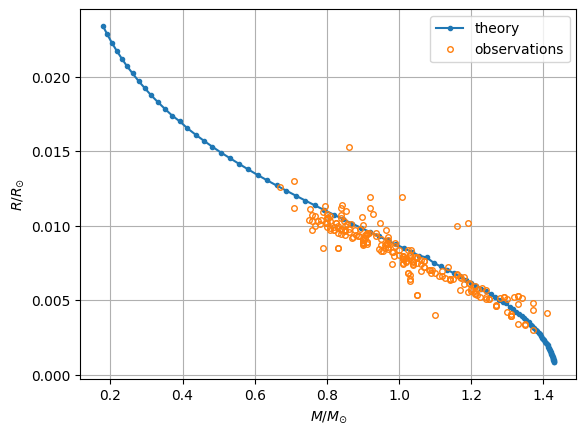

In [32]:

# The constants in the plot command convert our dimensionless units to the units of the solar mass and solar radius
plot(mass*0.71, radi*0.006, marker=".",label="theory") 
plot(df.Mass, df.Rad, marker="o", linestyle="none", 
     fillstyle="none", markersize=4, label="observations")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
legend();